# kNN для произвольных метрик близости

### Сколько очков наберет игрок в сезоне?

In [4]:
import pandas as pd
import numpy as np

- player – имя игрока
- pos – роль игрока на поле
- g – количество матчей, в которых участвовал игрок
- gs – количество матчей, в которых игрок был на поле с самого начала
- pts – общее количество очков

pos:
- SF small forward
- C center
- PF power forward
- SG shooting guard
- PG point guard
- G guard
- F forward

In [5]:
data = pd.read_csv( 'nba_2013.csv' )

Для построения модели возьмем несколько столбцов

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        481 non-null    object 
 1   pos           481 non-null    object 
 2   age           481 non-null    int64  
 3   bref_team_id  481 non-null    object 
 4   g             481 non-null    int64  
 5   gs            481 non-null    int64  
 6   mp            481 non-null    int64  
 7   fg            481 non-null    int64  
 8   fga           481 non-null    int64  
 9   fg.           479 non-null    float64
 10  x3p           481 non-null    int64  
 11  x3pa          481 non-null    int64  
 12  x3p.          414 non-null    float64
 13  x2p           481 non-null    int64  
 14  x2pa          481 non-null    int64  
 15  x2p.          478 non-null    float64
 16  efg.          479 non-null    float64
 17  ft            481 non-null    int64  
 18  fta           481 non-null    

In [7]:
predictionColumns = ['ft', 'x3p', 'x2p']

In [8]:
dataForPrediction = data[ predictionColumns ]
dataForPrediction.head()

,ft,x3p,x2p
0,35,4,62
1,79,0,93
2,76,0,143
3,274,128,336
4,56,0,136


pos - категориальная переменная, надо перевести в количественную

In [9]:
dataForPrediction = pd.get_dummies( dataForPrediction )
dataForPrediction.head()

,ft,x3p,x2p
0,35,4,62
1,79,0,93
2,76,0,143
3,274,128,336
4,56,0,136


Названия колонок нашего dataframe изменились

In [10]:
predictionColumns = dataForPrediction.columns.values
predictionColumns

array(['ft', 'x3p', 'x2p'], dtype=object)

Проведем нормализацию данных

In [11]:
#dataNormalized = ( dataForPrediction - dataForPrediction.mean() ) / dataForPrediction.std()
dataNormalized = dataForPrediction
dataNormalized.head()

,ft,x3p,x2p
0,35,4,62
1,79,0,93
2,76,0,143
3,274,128,336
4,56,0,136


Проверим, что у всех столбцов среднее 0 и среднеквадратичное отклонение 1

In [12]:
dataNormalized.describe()

,ft,x3p,x2p
count,481.000000,481.000000,481.000000
mean,91.205821,39.613306,153.268191
std,103.667725,50.855639,147.223161
min,0.000000,0.000000,0.000000
25%,16.000000,0.000000,31.000000
50%,53.000000,16.000000,110.000000
75%,126.000000,68.000000,230.000000
max,703.000000,261.000000,706.000000


Выберем игрока, для которого будем искать наиболее близких

In [13]:
selectedPlayer = dataNormalized.loc[ 10 ]
selectedPlayer

ft      91
x3p     13
x2p    221
Name: 10, dtype: int64

In [14]:
def euclidean_distance( player, selectedPlayer ):
    """
    Считаем "расстояние" между выбранным игроком selected_player и текущим player.
    В нашем случае это обычное евклидово расстояние
    """
      
    dist = 0
    for metricName in predictionColumns:
        dist += ( player[ metricName ] - selectedPlayer[ metricName ] )**2
    
    return dist**0.5

In [15]:
def euclidean_distance2( x, y ):
    """
    Считаем "расстояние" между выбранным игроком selected_player и текущим player.
    Аналогичный расчет для использования в модели KNeighborsRegressor
    """
    
    return np.sum( (x-y)**2 )**0.5

In [18]:
def ptsDiff( player, selectedPlayer ):
    return abs((player.ft - selectedPlayer.ft) + (player.x2p - selectedPlayer.x2p) * 2 + (player.x3p - selectedPlayer.x3p) * 3)

In [16]:
def ptsDiff2( player, selectedPlayer ):
    return abs((player[0] - selectedPlayer[0]) + (player[1] - selectedPlayer[1]) * 3 + (player[2] - selectedPlayer[2]) * 2)

Введем новый столбец "близости" игроков к выбранному

In [19]:
#dataNormalized['distance'] = dataNormalized.apply( euclidean_distance, axis = 1, args = (selectedPlayer,) )
dataNormalized['distance'] = dataNormalized.apply( ptsDiff, axis = 1, args = (selectedPlayer,) )
dataNormalized.head()

,ft,x3p,x2p,distance
0,35,4,62,401
1,79,0,93,307
2,76,0,143,210
3,274,128,336,758
4,56,0,136,244


Объединяем вычисления с исходными данными

In [20]:
dataWithDistance = data.join( dataNormalized['distance'] )
dataWithDistance[:11]

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,trb,ast,stl,blk,tov,pf,pts,season,season_end,distance
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,216,28,23,26,30,122,171,2013-2014,2013,401
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,332,43,40,57,71,203,265,2013-2014,2013,307
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,306,38,24,36,39,108,362,2013-2014,2013,210
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,262,248,35,3,146,136,1330,2013-2014,2013,758
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,277,40,23,46,63,187,328,2013-2014,2013,244
5,Cole Aldrich,C,25,NYK,46,2,330,33,61,0.541,...,129,14,8,30,18,40,92,2013-2014,2013,480
6,LaMarcus Aldridge,PF,28,POR,69,69,2498,652,1423,0.458,...,765,178,63,68,123,147,1603,2013-2014,2013,1031
7,Lavoy Allen,PF,24,TOT,65,2,1072,134,300,0.447,...,311,71,24,33,44,126,303,2013-2014,2013,269
8,Ray Allen,SG,38,MIA,73,9,1936,240,543,0.442,...,205,143,54,8,84,115,701,2013-2014,2013,129
9,Tony Allen,SG,32,MEM,55,28,1278,204,413,0.494,...,208,94,90,19,90,121,495,2013-2014,2013,77


In [21]:
dataWithDistance.sort_values( by = 'distance', ascending = True ).head(11)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,trb,ast,stl,blk,tov,pf,pts,season,season_end,distance
10,Al-Farouq Aminu,SF,23,NOP,80,65,2045,234,494,0.474,...,496,114,82,38,88,147,572,2013-2014,2013,0
45,Patrick Beverley,SG,25,HOU,56,55,1751,199,481,0.414,...,196,151,77,23,66,174,573,2013-2014,2013,1
214,Kris Humphries,PF,28,BOS,69,30,1376,231,461,0.501,...,409,67,31,61,64,136,579,2013-2014,2013,7
304,Mike Miller,SF,33,MEM,82,4,1707,213,443,0.481,...,207,130,26,5,77,95,579,2013-2014,2013,7
13,Alan Anderson,SF,31,BRK,78,26,1773,194,485,0.400,...,175,81,48,11,62,147,564,2013-2014,2013,8
427,Jason Thompson,PF,27,SAC,82,61,2007,251,496,0.506,...,527,53,32,56,95,251,586,2013-2014,2013,14
31,Andrea Bargnani,C,28,NYK,42,39,1257,222,502,0.442,...,222,45,14,52,58,100,558,2013-2014,2013,14
73,Caron Butler,SF,33,TOT,56,13,1419,213,540,0.394,...,229,82,47,17,60,120,587,2013-2014,2013,15
216,Andre Iguodala,SF,30,GSW,63,63,2040,220,458,0.480,...,293,263,95,18,100,103,588,2013-2014,2013,16
346,Patrick Patterson,PF,24,TOT,65,13,1533,225,489,0.460,...,342,78,55,37,65,159,555,2013-2014,2013,17


Первую строчку не учитываем (это и был selected_player)

Считаем среднее для первых пяти игроков самых близких игроков

In [22]:
dataWithDistance.sort_values( by = 'distance', ascending = True ).iloc[1:11]['pts'].mean()

576.1

## Задание

#### 1. Улучшить точность предсказания.

#### 2. Сделать то же самое с помощью KNeighborsRegressor

In [344]:
from sklearn.neighbors import KNeighborsRegressor

In [345]:
X = dataNormalized.drop('distance', axis=1)
X

,ft,x3p,x2p
0,35,4,62
1,79,0,93
2,76,0,143
3,274,128,336
4,56,0,136
...,...,...,...
476,209,40,305
477,235,135,252
478,163,90,492
479,146,0,172


In [377]:
knn = KNeighborsRegressor( 10, weights = 'distance', metric='pyfunc', metric_params={ 'func': ptsDiff2 } )

In [378]:
data[['pts']][0:1]

,pts
0,171


In [379]:
model = knn.fit( X, data[['pts']] )

In [380]:
model.predict(X.iloc[[0]])

array([[171.]])

In [381]:
predict = model.predict(X)

In [382]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

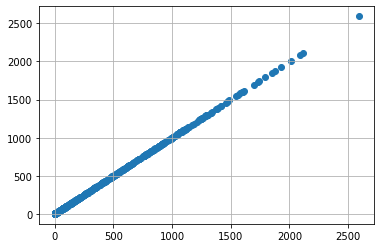

In [383]:
plt.scatter(data[['pts']], predict)
plt.grid()